<a href="https://colab.research.google.com/github/yinma-ml/Forecasting/blob/master/ShanghaiIndex_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Forecasting Shanghai Index using LSTM
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from datetime import datetime
start_time = datetime.now()


In [7]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# converting data for supervised learning
def get_train_set(data_set, timesteps_in, timesteps_out=1):
    train_data_set = np.array(data_set)
    reframed_train_data_set = np.array(series_to_supervised(train_data_set, timesteps_in, timesteps_out).values)
    print(reframed_train_data_set)
    print(reframed_train_data_set.shape)
    train_x, train_y = reframed_train_data_set[:, :-timesteps_out], reframed_train_data_set[:, -timesteps_out:]
    # reshaping data:[sample size, time step, features]
    train_x = train_x.reshape((train_x.shape[0], timesteps_in, 1))
    return train_x, train_y

"""
 converting time series data for supervised learning:
 define length for input and output series
 data:observed series
 n_in:observations' input(x) step, range [1,len(data)], default=1
 n_out:observations's output(x) step,range[0,len(data)-1],default =1 
 dropna:drop nan row
 return: dataframe that suits supervised learning
 """
def series_to_supervised(data, n_in=1, n_out=1, dropna=True):
   n_vars = 1 if type(data) is list else data.shape[1]
   df = DataFrame(data)
   cols,names = list(),list()
   # input sequence(t-n, . . ., t-1)
   for i in range(n_in,0,-1):
       cols.append(df.shift(i))
       names +=[('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
   #forcast array (t, t+1, ... t+n)
   for i in range(0,n_out):
      cols.append(df.shift(-i)) 
      if i ==0:
          names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
   #append
   agg =concat(cols,axis=1)
   agg.columns=names
   #drop nan
   if dropna:
       agg.dropna(inplace=True)
   return agg



In [9]:
# forecasting
def lstm_model(source_data_set, train_x, label_y, input_epochs, input_batch_size, timesteps_out):
    model = Sequential()
    
    # 1st layer: hide, nodes=128, return to the whole sequences
    model.add(LSTM(128, return_sequences=True, activation='tanh', input_shape=(train_x.shape[1], train_x.shape[2])))
    # 2nd，hide, nodes=128, only return sequence's last output
    model.add(LSTM(128, return_sequences=False))
    model.add(Dropout(0.5))
    # 3rd, regression, linear
    model.add(Dense(timesteps_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # LSTM training,# input_epochs, verbose = 2 (2: ecch epoch has one row of output record, =1 output processing record,  =0 no record)
    res = model.fit(train_x, label_y, epochs=input_epochs, batch_size=input_batch_size, verbose=2, shuffle=False)

    # forecasting
    train_predict = model.predict(train_x)
    #test_data_list = list(chain(*test_data))
    train_predict_list = list(chain(*train_predict))

    plt.plot(res.history['loss'], label='train')
    plt.show()
    print(model.summary())
    plot_img(source_data_set, train_predict)

# show original, trained, tested and forcasted results
def plot_img(source_data_set, train_predict):
    plt.figure(figsize=(24, 8))
    # plot original data in blue
    plt.plot(source_data_set[:, -1], c='b')
    # plot train data in green
    plt.plot([x for x in train_predict], c='g')
    plt.legend()
    plt.show()

 
   

Streaming output truncated to the last 5000 lines.
72/72 - 1s - loss: 57929.4258
Epoch 7502/10000
72/72 - 1s - loss: 67998.5469
Epoch 7503/10000
72/72 - 1s - loss: 97263.5781
Epoch 7504/10000
72/72 - 1s - loss: 74780.1250
Epoch 7505/10000
72/72 - 1s - loss: 71092.1797
Epoch 7506/10000
72/72 - 1s - loss: 63412.5547
Epoch 7507/10000
72/72 - 1s - loss: 72109.7188
Epoch 7508/10000
72/72 - 1s - loss: 62103.9766
Epoch 7509/10000
72/72 - 1s - loss: 58588.8281
Epoch 7510/10000
72/72 - 1s - loss: 62424.6953
Epoch 7511/10000
72/72 - 1s - loss: 59081.6133
Epoch 7512/10000
72/72 - 1s - loss: 60828.9023
Epoch 7513/10000
72/72 - 1s - loss: 59026.6406
Epoch 7514/10000
72/72 - 1s - loss: 56825.6211
Epoch 7515/10000
72/72 - 1s - loss: 59159.6055
Epoch 7516/10000
72/72 - 1s - loss: 64726.7891
Epoch 7517/10000
72/72 - 1s - loss: 72308.0859
Epoch 7518/10000
72/72 - 1s - loss: 61938.6797
Epoch 7519/10000
72/72 - 1s - loss: 81483.5391
Epoch 7520/10000
72/72 - 1s - loss: 62452.7695
Epoch 7521/10000
72/72 - 1

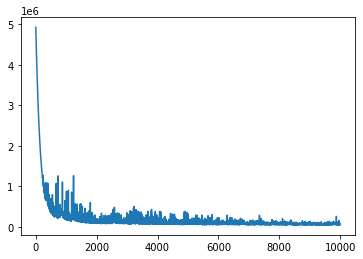

No handles with labels found to put in legend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 3, 128)            66560     
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 198,531
Trainable params: 198,531
Non-trainable params: 0
_________________________________________________________________
None


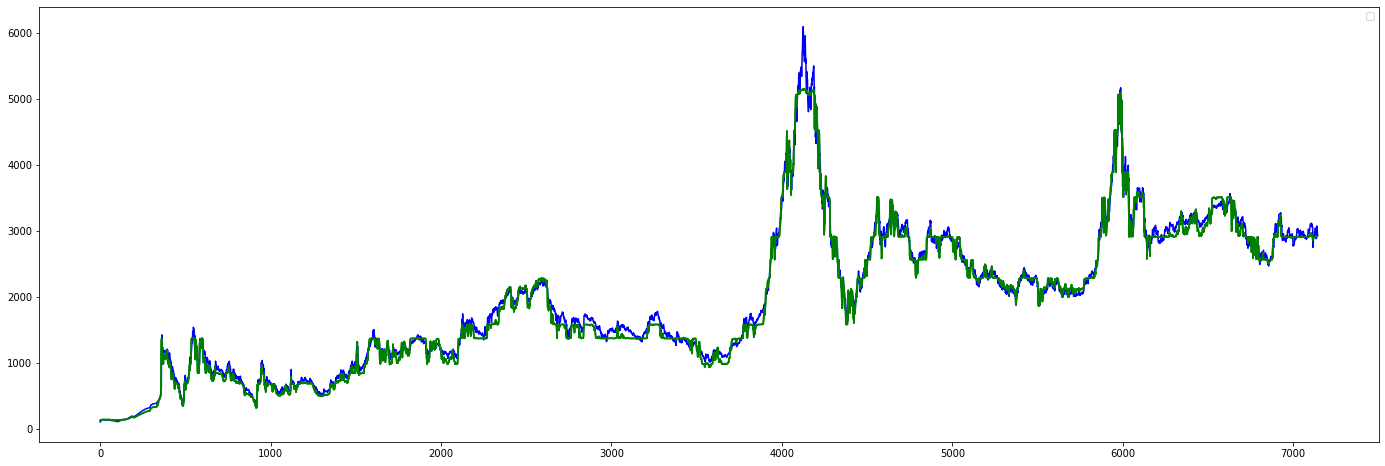

In [10]:
# set observations input(X)'s timestep，epochs，batch_size
timesteps_in = 3
timesteps_out = 3
epochs = 10000  # 500: predictions are kinda flat, under-fit, not sufficient, then enlarge the number. 
# also can see the loss to find if there's space for reduction
batch_size = 100
 
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/shanghai_index_1990_12_19_to_2020_03_12.csv')
 
data_set = data[['Price']].values.astype('float64')
# converting data for supervised learning
train_x, label_y = get_train_set(data_set, timesteps_in=timesteps_in, timesteps_out=timesteps_out)

# use LSTM for training and forecasting
lstm_model(data_set, train_x, label_y, epochs, batch_size, timesteps_out=timesteps_out)

In [11]:
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Duration: 3:20:05.064304
